# Settings

In [1]:
EXP_NO = 4
SEED = 1
N_SPLITS = 5
TARGET = 'target'
GROUP = 'art_series_id'

# Library

In [2]:
from collections import defaultdict
from functools import partial
import gc
import glob
import json
from logging import getLogger, StreamHandler, FileHandler, DEBUG, Formatter
import pickle
import os
import sys
import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error, cohen_kappa_score

SCRIPTS_DIR = os.path.join('..', 'scripts')
assert(os.path.isdir(SCRIPTS_DIR))
if SCRIPTS_DIR not in sys.path: sys.path.append(SCRIPTS_DIR)
from folder import experiment_dir_of
from dataset import load_csvfiles, load_photofiles
from cross_validation import load_cv_object_ids

In [3]:
pd.options.display.float_format = '{:.5f}'.format

# Prepare directory

In [4]:
output_dir = experiment_dir_of(EXP_NO)

In [5]:
output_dir

'..\\scripts\\..\\experiments\\exp004'

# Prepare logger

In [6]:
logger = getLogger(__name__)

In [7]:
'''Refference
https://docs.python.org/ja/3/howto/logging-cookbook.html
'''
logger.setLevel(DEBUG)
# create file handler which logs even debug messages
fh = FileHandler(os.path.join(output_dir, 'log.log'))
fh.setLevel(DEBUG)
# create console handler with a higher log level
ch = StreamHandler()
ch.setLevel(DEBUG)
# create formatter and add it to the handlers
formatter = Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(fh)
logger.addHandler(ch)
len(logger.handlers)

2

In [8]:
logger.info('Experiment no: {}'.format(EXP_NO))
logger.info('CV: StratifiedGroupKFold')
logger.info('SEED: {}'.format(SEED))

2021-07-17 02:07:56,063 - __main__ - INFO - Experiment no: 4
2021-07-17 02:07:56,069 - __main__ - INFO - CV: StratifiedGroupKFold
2021-07-17 02:07:56,071 - __main__ - INFO - SEED: 1


# Load csv files

In [9]:
SINCE = time.time()

In [10]:
logger.debug('Start loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))
train, test, materials, techniques, sample_submission = load_csvfiles()
logger.debug('Complete loading csv files ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 02:07:56,112 - __main__ - DEBUG - Start loading csv files (0.020 seconds passed)
2021-07-17 02:07:56,146 - __main__ - DEBUG - Complete loading csv files (0.054 seconds passed)


In [11]:
train

,object_id,sorting_date,art_series_id,target
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...,...
3932,ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
3933,ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
3934,ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2
3935,ffe49bba69d06446de7e,1805,f5287bc84a05aada1d17,3


In [12]:
test

,object_id
0,0009e50b94be36ccad39
1,000bd5e82eb22f199f44
2,0015f44de1854f617516
3,00388a678879ba1efa27
4,005e1e7c6496902d23f3
...,...
5914,ffbe65ad399b632dcbd0
5915,ffd7b2d646c0320c311a
5916,ffdb93ede17d4501e530
5917,ffe111402004b0ed46b4


# Load features

In [13]:
%%time
features = pd.read_csv(os.path.join('exp003', 'features.csv')).rename(columns={'Unnamed: 0': 'object_id'}).set_index('object_id')
features

Wall time: 155 ms


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
object_id,,,,,,,,,,,,,,,,,,,,,
002bff09b09998d0be65,6.02342,6.03538,-6.29166,6.09582,-6.63066,-6.29910,-6.26897,-6.22625,-6.34322,-6.37667,...,-6.17740,6.59218,-5.99844,-6.34549,6.20194,6.24396,6.30331,-6.27070,-6.46921,6.43648
00309fb1ef05416f9c1f,4.71163,4.79944,-4.97370,4.79243,-5.22997,-5.00007,-4.87673,-4.91137,-5.01472,-5.02607,...,-4.84375,5.17189,-4.74816,-5.00026,4.91912,4.91728,4.99318,-4.90027,-5.11544,5.12447
003a1562e97f79ba96dc,6.95182,7.06783,-7.34767,7.08927,-7.70432,-7.35349,-7.24841,-7.24969,-7.40431,-7.41507,...,-7.19515,7.64209,-7.02728,-7.35022,7.17197,7.23841,7.35748,-7.29294,-7.53360,7.50927
004890880e8e7431147b,6.61670,6.66414,-6.97066,6.70350,-7.33669,-7.00060,-6.84257,-6.83445,-6.97711,-7.03149,...,-6.82821,7.25377,-6.61397,-6.93663,6.74997,6.83376,6.94486,-6.89892,-7.11248,7.12903
00718c32602425f504c1,6.34380,6.43173,-6.67485,6.43222,-7.02094,-6.69404,-6.54063,-6.63774,-6.78988,-6.68474,...,-6.51852,6.97555,-6.38942,-6.73712,6.51352,6.62985,6.69154,-6.57067,-6.84308,6.85030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbe65ad399b632dcbd0,6.05175,6.11740,-6.37339,6.14629,-6.69496,-6.38666,-6.30279,-6.26159,-6.44378,-6.40852,...,-6.24618,6.62519,-6.13225,-6.35555,6.22296,6.28315,6.37095,-6.30695,-6.51919,6.54305
ffd7b2d646c0320c311a,6.32570,6.54714,-6.76076,6.58601,-7.10817,-6.80362,-6.65212,-6.66384,-6.82759,-6.80831,...,-6.62203,7.05994,-6.53526,-6.77721,6.64991,6.73637,6.83354,-6.73508,-6.90117,6.95371
ffdb93ede17d4501e530,6.14850,6.18295,-6.43857,6.23233,-6.76942,-6.54331,-6.38327,-6.40903,-6.49309,-6.49412,...,-6.31906,6.74580,-6.18386,-6.48356,6.32764,6.34051,6.48582,-6.41988,-6.70148,6.68402


# Cross validation

In [14]:
X_test = features.loc[test['object_id']]
X_test

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
object_id,,,,,,,,,,,,,,,,,,,,,
0009e50b94be36ccad39,4.22597,4.26324,-4.47005,4.31562,-4.66806,-4.47951,-4.41868,-4.43803,-4.47603,-4.48017,...,-4.37031,4.62875,-4.25895,-4.44120,4.33815,4.36361,4.41832,-4.40739,-4.55633,4.57539
000bd5e82eb22f199f44,3.76429,3.73178,-3.89812,3.81069,-4.12026,-3.91197,-3.86650,-3.90220,-3.99607,-3.99884,...,-3.82749,4.08183,-3.74918,-3.97655,3.79813,3.92394,3.92109,-3.87581,-4.01766,4.02353
0015f44de1854f617516,6.44165,6.48089,-6.74841,6.60568,-7.13350,-6.84012,-6.70837,-6.76542,-6.82982,-6.88060,...,-6.71564,7.04490,-6.51387,-6.72373,6.64535,6.64618,6.77314,-6.75558,-6.94241,6.96164
00388a678879ba1efa27,6.99331,7.06574,-7.25531,7.12971,-7.72206,-7.37203,-7.30992,-7.30795,-7.37547,-7.43454,...,-7.24329,7.65047,-6.98554,-7.33966,7.18023,7.21441,7.32273,-7.28466,-7.50525,7.51356
005e1e7c6496902d23f3,5.25428,5.35466,-5.56399,5.36518,-5.92184,-5.59754,-5.52230,-5.39331,-5.65160,-5.65133,...,-5.49662,5.82625,-5.28489,-5.62246,5.41192,5.54552,5.63101,-5.48754,-5.70735,5.79411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbe65ad399b632dcbd0,6.05175,6.11740,-6.37339,6.14629,-6.69496,-6.38666,-6.30279,-6.26159,-6.44378,-6.40852,...,-6.24618,6.62519,-6.13225,-6.35555,6.22296,6.28315,6.37095,-6.30695,-6.51919,6.54305
ffd7b2d646c0320c311a,6.32570,6.54714,-6.76076,6.58601,-7.10817,-6.80362,-6.65212,-6.66384,-6.82759,-6.80831,...,-6.62203,7.05994,-6.53526,-6.77721,6.64991,6.73637,6.83354,-6.73508,-6.90117,6.95371
ffdb93ede17d4501e530,6.14850,6.18295,-6.43857,6.23233,-6.76942,-6.54331,-6.38327,-6.40903,-6.49309,-6.49412,...,-6.31906,6.74580,-6.18386,-6.48356,6.32764,6.34051,6.48582,-6.41988,-6.70148,6.68402


In [15]:
train.set_index('object_id', inplace=True)

In [16]:
train

,sorting_date,art_series_id,target
object_id,,,
002bff09b09998d0be65,1631,509357f67692a6a45626,1
00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3
003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3
004890880e8e7431147b,1743,582ac2d7f0cef195b605,2
00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3
...,...,...,...
ffa3259fff8e6f3818a1,1850,b187c294b0550acf049a,3
ffd4d361756587883e48,1670,ad49a044770a48f860a6,1
ffd794b7b311b7b7fd92,1789,f030a01b480b18a27be2,2


In [17]:
fold_object_ids = load_cv_object_ids()
for i, (train_object_ids, valid_object_ids) in enumerate(zip(fold_object_ids[0], fold_object_ids[1])):
    assert(set(train_object_ids) & set(valid_object_ids) == set())
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))
    # Separate dataset into training/validation fold
    X_train = features.loc[train_object_ids]
    y_train = train.loc[train_object_ids, TARGET]
    X_valid = features.loc[valid_object_ids]
    y_valid = train.loc[valid_object_ids, TARGET]
    
    # Training
    logger.debug('Start training model ({:.3f} seconds passed)'.format(time.time() - SINCE))
    ## train estimator
    estimator = lgbm.LGBMClassifier(importance_type='gain', random_state=SEED,
                                    n_jobs=-1, class_weight='balanced')
    estimator.fit(X_train, y_train)
    logger.debug('Complete training ({:.3f} seconds passed)'.format(time.time() - SINCE))
    
    # Save model and prediction
    ## Training set
    pred_train = pd.DataFrame(data=estimator.predict_proba(X_train),
                              columns=estimator.classes_)
    pred_train['object_id'] = train_object_ids
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train.to_csv(filepath_fold_train, index=False)
    logger.debug('Save training fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_train, time.time() - SINCE))
    ## Validation set
    pred_valid = pd.DataFrame(data=estimator.predict_proba(X_valid),
                              columns=estimator.classes_)
    pred_valid['object_id'] = valid_object_ids
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid.to_csv(filepath_fold_valid, index=False)
    logger.debug('Save validation fold to {} ({:.3f} seconds passed)' \
                .format(filepath_fold_valid, time.time() - SINCE))
    ## Test set
    pred_test = pd.DataFrame(data=estimator.predict_proba(X_test),
                             columns=estimator.classes_)
    pred_test['object_id'] = test['object_id'].values
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test.to_csv(filepath_fold_test, index=False)
    logger.debug('Save test result {} ({:.3f} seconds passed)' \
                 .format(filepath_fold_test, time.time() - SINCE))
    ## Model
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'wb') as f:
        pickle.dump(estimator, f)
    logger.debug('Save model {} ({:.3f} seconds passed)'.format(filepath_fold_model, time.time() - SINCE))
    
    # Save memory
    del (estimator, X_train, X_valid, y_train, y_valid, pred_train, pred_valid, pred_test)
    gc.collect()

    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

2021-07-17 02:07:56,533 - __main__ - DEBUG - Start fold 1 (0.441 seconds passed)
2021-07-17 02:07:56,544 - __main__ - DEBUG - Start training model (0.452 seconds passed)
2021-07-17 02:07:57,790 - __main__ - DEBUG - Complete training (1.697 seconds passed)
2021-07-17 02:07:57,900 - __main__ - DEBUG - Save training fold to ..\scripts\..\experiments\exp004\cv_fold1_training.csv (1.808 seconds passed)
2021-07-17 02:07:57,939 - __main__ - DEBUG - Save validation fold to ..\scripts\..\experiments\exp004\cv_fold1_validation.csv (1.847 seconds passed)
2021-07-17 02:07:58,119 - __main__ - DEBUG - Save test result ..\scripts\..\experiments\exp004\cv_fold1_test.csv (2.027 seconds passed)
2021-07-17 02:07:58,167 - __main__ - DEBUG - Save model ..\scripts\..\experiments\exp004\cv_fold1_model.pkl (2.075 seconds passed)
2021-07-17 02:07:58,242 - __main__ - DEBUG - Complete fold 1 (2.150 seconds passed)
2021-07-17 02:07:58,243 - __main__ - DEBUG - Start fold 2 (2.151 seconds passed)
2021-07-17 02:07:5

# Evaluation

In [18]:
rmse = partial(mean_squared_error, squared=False)

In [19]:
qwk = partial(cohen_kappa_score, labels=np.sort(train['target'].unique()), weights='quadratic')

In [20]:
@np.vectorize
def predict(proba_0: float, proba_1: float, proba_2: float, proba_3: float) -> int:
    return np.argmax((proba_0, proba_1, proba_2, proba_3))

In [21]:
metrics = defaultdict(list)

## Training set

In [22]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (training set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_train = os.path.join(output_dir, f'cv_fold{num_fold}_training.csv')
    pred_train_df = pd.read_csv(filepath_fold_train)
    pred_train_df['pred'] = predict(pred_train_df['0'], pred_train_df['1'],
                                    pred_train_df['2'], pred_train_df['3'])
    pred_train_df['actual'] = train.loc[pred_train_df['object_id'], TARGET].values
    print(confusion_matrix(pred_train_df['actual'], pred_train_df['pred'],
                           labels=np.sort(train['target'].unique())))
    loss = rmse(pred_train_df['actual'], pred_train_df['pred'])
    score = qwk(pred_train_df['actual'], pred_train_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    logger.debug('Score: {}'.format(score))
    metrics['train_losses'].append(loss)
    metrics['train_scores'].append(score)
    pred_train_dfs.append(pred_train_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])
metrics['train_scores_avg'] = np.mean(metrics['train_scores'])
metrics['train_scores_std'] = np.std(metrics['train_scores'])

2021-07-17 02:08:05,186 - __main__ - DEBUG - Evaluate cv result (training set) Fold 1
2021-07-17 02:08:05,234 - __main__ - DEBUG - Loss: 0.22502653771313116
2021-07-17 02:08:05,235 - __main__ - DEBUG - Score: 0.973074764205993
2021-07-17 02:08:05,235 - __main__ - DEBUG - Evaluate cv result (training set) Fold 2
2021-07-17 02:08:05,279 - __main__ - DEBUG - Loss: 0.21711052938015635
2021-07-17 02:08:05,280 - __main__ - DEBUG - Score: 0.975061277355201
2021-07-17 02:08:05,282 - __main__ - DEBUG - Evaluate cv result (training set) Fold 3
2021-07-17 02:08:05,331 - __main__ - DEBUG - Loss: 0.25893625123816644
2021-07-17 02:08:05,332 - __main__ - DEBUG - Score: 0.9646098460668981
2021-07-17 02:08:05,333 - __main__ - DEBUG - Evaluate cv result (training set) Fold 4
2021-07-17 02:08:05,379 - __main__ - DEBUG - Loss: 0.24487124970892388
2021-07-17 02:08:05,380 - __main__ - DEBUG - Score: 0.9679942578261832
2021-07-17 02:08:05,381 - __main__ - DEBUG - Evaluate cv result (training set) Fold 5


[[ 368    0    0    1]
 [   1  708    2    3]
 [   9   19 1160   18]
 [   2    9    8  832]]
[[ 381    0    0    3]
 [   1  705    3    6]
 [   4   18 1178   15]
 [   2    5    7  833]]
[[ 378    0    0    0]
 [   2  695    3    7]
 [   7   13 1165   16]
 [   5   14   20  822]]
[[ 380    0    0    2]
 [   0  700    5    8]
 [   9   19 1189   20]
 [   2    9    5  804]]
[[ 385    1    0    1]
 [   0  723    3    9]
 [   5   13 1151   16]
 [   6   10   15  810]]


2021-07-17 02:08:05,438 - __main__ - DEBUG - Loss: 0.2564293968681143
2021-07-17 02:08:05,443 - __main__ - DEBUG - Score: 0.9654576816366515


In [23]:
pred_train = pd.concat(pred_train_dfs).groupby('object_id').sum()
pred_train = pred_train / N_SPLITS
pred_train['pred'] = predict(pred_train['0'], pred_train['1'], pred_train['2'], pred_train['3'])
pred_train['actual'] = train.loc[pred_train.index, TARGET].values
pred_train

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,0.05234,0.49869,0.14717,0.10179,1,1
00309fb1ef05416f9c1f,0.03321,0.06992,0.05411,0.64276,3,3
003a1562e97f79ba96dc,0.03548,0.03356,0.09073,0.64023,3,3
004890880e8e7431147b,0.02631,0.04788,0.50695,0.21885,2,2
00718c32602425f504c1,0.05760,0.17342,0.12863,0.44035,3,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,0.05891,0.12225,0.15949,0.45936,3,3
ffd4d361756587883e48,0.08790,0.40701,0.15320,0.15189,1,1
ffd794b7b311b7b7fd92,0.10684,0.15365,0.38301,0.15650,2,2


In [24]:
print(confusion_matrix(pred_train['actual'], pred_train['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_train['actual'], pred_train['pred'])
score = qwk(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = loss
metrics['train_score'] = score
logger.info('Training loss: {}'.format(loss))
logger.info('Training score: {}'.format(score))

2021-07-17 02:08:05,546 - __main__ - INFO - Training loss: 0.13985005940677406
2021-07-17 02:08:05,549 - __main__ - INFO - Training score: 0.9895894979374157


[[ 474    0    0    1]
 [   0  885    4    7]
 [   1    3 1499    8]
 [   1    2    4 1048]]


In [25]:
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_train.csv')))

2021-07-17 02:08:05,598 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp004\prediction_train.csv


## Validation set

In [26]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    logger.debug('Evaluate cv result (validation set) Fold {}'.format(num_fold))
    # Read cv result
    filepath_fold_valid = os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv')
    pred_valid_df = pd.read_csv(filepath_fold_valid)
    pred_valid_df['pred'] = predict(pred_valid_df['0'], pred_valid_df['1'],
                                    pred_valid_df['2'], pred_valid_df['3'])
    pred_valid_df['actual'] = train.loc[pred_valid_df['object_id'], TARGET].values
    print(confusion_matrix(pred_valid_df['actual'], pred_valid_df['pred'],
                           labels=np.sort(train['target'].unique())))
    loss = rmse(pred_valid_df['actual'], pred_valid_df['pred'])
    score = qwk(pred_valid_df['actual'], pred_valid_df['pred'])
    logger.debug('Loss: {}'.format(loss))
    logger.debug('Score: {}'.format(score))
    metrics['valid_losses'].append(loss)
    metrics['valid_scores'].append(score)
    pred_valid_dfs.append(pred_valid_df)
    
metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])
metrics['valid_scores_avg'] = np.mean(metrics['valid_scores'])
metrics['valid_scores_std'] = np.std(metrics['valid_scores'])

2021-07-17 02:08:05,617 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 1


[[ 16  27  28  35]
 [ 20  51  62  49]
 [ 33  64 130  78]
 [ 19  43  83  59]]

2021-07-17 02:08:05,650 - __main__ - DEBUG - Loss: 1.340424472555184
2021-07-17 02:08:05,651 - __main__ - DEBUG - Score: 0.04612802717267761
2021-07-17 02:08:05,651 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 2
2021-07-17 02:08:05,675 - __main__ - DEBUG - Loss: 1.4032363182830088
2021-07-17 02:08:05,676 - __main__ - DEBUG - Score: -0.006531220660863868
2021-07-17 02:08:05,677 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 3
2021-07-17 02:08:05,703 - __main__ - DEBUG - Loss: 1.3278897315818459
2021-07-17 02:08:05,705 - __main__ - DEBUG - Score: 0.03579357972596686
2021-07-17 02:08:05,707 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 4



[[ 10  23  33  25]
 [ 28  39  55  59]
 [ 43  62 110  81]
 [ 26  53  68  61]]
[[ 17  20  36  24]
 [ 19  41  70  59]
 [ 28  76 126  80]
 [ 19  44  73  58]]
[[ 15  29  32  17]
 [ 27  49  65  42]
 [ 27  55 112  80]
 [ 17  57  87  74]]

2021-07-17 02:08:05,730 - __main__ - DEBUG - Loss: 1.2774377220663096
2021-07-17 02:08:05,730 - __main__ - DEBUG - Score: 0.13803034939607217
2021-07-17 02:08:05,733 - __main__ - DEBUG - Evaluate cv result (validation set) Fold 5
2021-07-17 02:08:05,756 - __main__ - DEBUG - Loss: 1.3486133328050403
2021-07-17 02:08:05,759 - __main__ - DEBUG - Score: 0.027790300185732364



[[ 13  20  36  19]
 [ 19  39  64  39]
 [ 57  59 134  76]
 [ 25  47  85  57]]


In [27]:
pred_valid = pd.concat(pred_valid_dfs).groupby('object_id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['pred'] = predict(pred_valid['0'], pred_valid['1'], pred_valid['2'], pred_valid['3'])
pred_valid['actual'] = train.loc[pred_valid.index, TARGET].values
pred_valid

,0,1,2,3,pred,actual
object_id,,,,,,
002bff09b09998d0be65,0.00962,0.07661,0.02708,0.08669,3,1
00309fb1ef05416f9c1f,0.03665,0.09621,0.03137,0.03577,1,3
003a1562e97f79ba96dc,0.00563,0.03168,0.12027,0.04241,2,3
004890880e8e7431147b,0.03925,0.03119,0.05520,0.07436,3,2
00718c32602425f504c1,0.03799,0.05998,0.05551,0.04652,1,3
...,...,...,...,...,...,...
ffa3259fff8e6f3818a1,0.03677,0.03021,0.08166,0.05136,2,3
ffd4d361756587883e48,0.02908,0.03481,0.05334,0.08277,3,1
ffd794b7b311b7b7fd92,0.01293,0.06959,0.06923,0.04825,1,2


In [28]:
print(confusion_matrix(pred_valid['actual'], pred_valid['pred'], labels=np.sort(train['target'].unique())))
loss = rmse(pred_valid['actual'], pred_valid['pred'])
score = qwk(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = loss
metrics['valid_score'] = score
logger.info('Validatino loss: {}'.format(loss))
logger.info('Validatino score: {}'.format(score))

2021-07-17 02:08:05,846 - __main__ - INFO - Validatino loss: 1.3399737277496087
2021-07-17 02:08:05,847 - __main__ - INFO - Validatino score: 0.04714661344234017


[[ 71 119 165 120]
 [113 219 316 248]
 [188 316 612 395]
 [106 244 396 309]]


In [29]:
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))
logger.debug('Write cv result to {}'.format(os.path.join(output_dir, 'prediction_valid.csv')))

2021-07-17 02:08:05,897 - __main__ - DEBUG - Write cv result to ..\scripts\..\experiments\exp004\prediction_valid.csv


In [30]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(dict(metrics), f)
logger.debug('Write metrics to {}'.format(os.path.join(output_dir, 'metrics.json')))

2021-07-17 02:08:05,918 - __main__ - DEBUG - Write metrics to ..\scripts\..\experiments\exp004\metrics.json


# Prediction

In [31]:
pred_test_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    filepath_fold_test = os.path.join(output_dir, f'cv_fold{num_fold}_test.csv')
    pred_test_df = pd.read_csv(filepath_fold_test)
    pred_test_dfs.append(pred_test_df)

In [32]:
pred_test = pd.concat(pred_test_dfs).groupby('object_id').sum()
pred_test = pred_test / N_SPLITS
pred_test['pred'] = predict(pred_test['0'], pred_test['1'], pred_test['2'], pred_test['3'])
pred_test

,0,1,2,3,pred
object_id,,,,,
0009e50b94be36ccad39,0.06962,0.03723,0.27878,0.61438,3
000bd5e82eb22f199f44,0.04806,0.22704,0.15980,0.56509,3
0015f44de1854f617516,0.17562,0.15552,0.49686,0.17200,2
00388a678879ba1efa27,0.24794,0.08976,0.16984,0.49245,3
005e1e7c6496902d23f3,0.37544,0.15676,0.32203,0.14577,0
...,...,...,...,...,...
ffbe65ad399b632dcbd0,0.12839,0.36867,0.26170,0.24124,1
ffd7b2d646c0320c311a,0.15671,0.31080,0.31897,0.21352,2
ffdb93ede17d4501e530,0.12406,0.24943,0.20878,0.41773,3


In [33]:
test['target'] = pred_test.loc[test['object_id'], 'pred'].values
test = test[['target']]
test

,target
0,3
1,3
2,2
3,3
4,0
...,...
5914,1
5915,2
5916,3
5917,2


In [34]:
sample_submission

,target
0,3
1,1
2,3
3,3
4,0
...,...
5914,2
5915,1
5916,1
5917,3


In [35]:
test.to_csv(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv'), index=False)
logger.debug('Write submission to {}'.format(os.path.join(output_dir, f'{str(EXP_NO).zfill(3)}_submission.csv')))

2021-07-17 02:08:06,175 - __main__ - DEBUG - Write submission to ..\scripts\..\experiments\exp004\004_submission.csv


2021-07-17 02:08:06,336 - __main__ - DEBUG - Write figure to ..\scripts\..\experiments\exp004\prediction.png


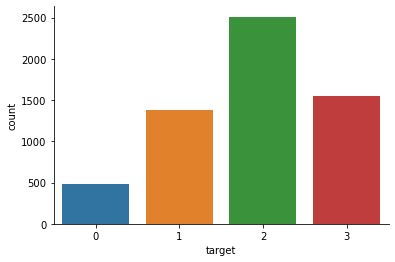

In [36]:
fig = plt.figure()
sns.countplot(data=test, x='target')
sns.despine()
fig.savefig(os.path.join(output_dir, 'prediction.png'))
logger.debug('Write figure to {}'.format(os.path.join(output_dir, 'prediction.png')))

In [37]:
logger.debug('Complete ({:.3f} seconds passed)'.format(time.time() - SINCE))

2021-07-17 02:08:06,419 - __main__ - DEBUG - Complete (10.327 seconds passed)
